## Install Required Libraries
Install the necessary libraries, including Gymnasium, Stable Baselines3, and SB3 Contrib.

In [1]:
# Importing required modules
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, DQN, A2C
from stable_baselines3.common.evaluation import evaluate_policy
from sb3_contrib.common.maskable.evaluation import evaluate_policy as evaluate_policy_maskable
import optuna

from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker

# Import BoundedKnapsack Environment
from knapsack_env import BoundedKnapsackEnv

# Setting the seed for reproducibility
seed = 2024
np.random.seed(seed)

# Create a log directory
log_dir = './logs/'
os.makedirs(log_dir, exist_ok=True)

In [2]:
# Define global variables
TIME_STEPS = 10000
EVAL_EPISODES = 100   
EVAL_FREQ = int(TIME_STEPS**0.5)     
VERBOSE = 0
N_TRIALS = 10

# Create an Instance of the Environment
Create an instance of the BoundedKnapsack environment with the specified parameters.

In [3]:
# Enable the environment
env = BoundedKnapsackEnv(n_items=200, max_weight=200)

# Create evaluation environment
eval_env = Monitor(env)

# Inspect the state space and action spaces
state_space = env.reset()
action_space_size = env.action_space.n

# Print the state space and action space size
print(f"State Space: {state_space}")
print(f"Action Space Size: {action_space_size}")

State Space: (array([[ 82,  65,  60,  69,  35,  87,  35,  48,  40,  23,  15,  86,   3,
         41,  26,  64,  42,  52,  95,  67,  17,  45,  93,  30,  53,  50,
         20,  74,  49,  66,   5,  48,  51,  19,  71,  51,  10,  93,  44,
         55,  28,  93,  31,  37,  88,  30,   6,   3,   9,   9,  37,  15,
         38,  83,  39,  26,  33,  98,  69,  82,  25,  90,  18,  57,  95,
         95,  60,  65,  38,  86,  57,  80,  75,  70,  10,  19,  20,  66,
         57,  42,  36,  30,  63,  35,  22,  34,  59,  80,  48,  56,  70,
         55,  20,  21,  83,  57,  43,  66,  71,  79,   3,  99,   7,  54,
         58,  79,  69,  43,  40,   6,  34,  73,  15,  19,  32,  82,  31,
          9,   2,  31,  54,  83,  68,  44,  59,  41,  63,  28,  95,  48,
         36,  98,  91,  71,  39,  31,  60,  11,  33,  10,  94,  93,  30,
         36,  34,  20,  99,  80,  85,  89,  49,  79,  85,  76,   3,  50,
         63,  11,  83,  40,  23,  68,  29,  55,  43,  12,  28,  21,  52,
         52,  44,  45,  46,  93,  24,

# Train and Test DRL Agents
Train and test at least two different DRL agents using the algorithms provided in Stable Baselines3 with default hyperparameters.

In [4]:
# Define the policy network architecture
policy_kwargs = dict(activation_fn=torch.nn.Tanh, net_arch=[64, 64])

# Training the PPO agent
ppo_model = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=VERBOSE)
ppo_model.learn(total_timesteps=TIME_STEPS)

# Training the DQN agent
dqn_model = DQN("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=VERBOSE, buffer_size=TIME_STEPS//10)
dqn_model.learn(total_timesteps=TIME_STEPS)

# Evaluating the PPO agent
mean_reward_ppo, std_reward_ppo = evaluate_policy(ppo_model, eval_env, n_eval_episodes=EVAL_EPISODES, deterministic=True)
print(f"Mean reward for PPO agent: {mean_reward_ppo} +/- {std_reward_ppo}")

# Evaluating the DQN agent
mean_reward_dqn, std_reward_dqn = evaluate_policy(dqn_model, eval_env, n_eval_episodes=EVAL_EPISODES, deterministic=True)
print(f"Mean reward for DQN agent: {mean_reward_dqn} +/- {std_reward_dqn}")

Mean reward for PPO agent: 255.0 +/- 0.0
Mean reward for DQN agent: 172.0 +/- 0.0


# Experiment with Different Neural Network Architectures
Experiment with different neural network architectures for the DRL agents with default hyperparameters.

In [5]:

# Define the policy network architecture
policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[128, 128])

# Training the PPO agent
ppo_model_large = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=VERBOSE)
ppo_model_large.learn(total_timesteps=TIME_STEPS)

# Training the DQN agent
dqn_model_large = DQN("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=VERBOSE, buffer_size=TIME_STEPS//10)
dqn_model_large.learn(total_timesteps=TIME_STEPS)

# Evaluating the PPO agent
mean_reward, std_reward = evaluate_policy(ppo_model_large, eval_env, n_eval_episodes=EVAL_EPISODES, deterministic=True)
print(f"Mean reward for PPO agent: {mean_reward} +/- {std_reward}")

# Evaluating the DQN agent
mean_reward, std_reward = evaluate_policy(dqn_model_large, eval_env, n_eval_episodes=EVAL_EPISODES, deterministic=True)
print(f"Mean reward for DQN agent: {mean_reward} +/- {std_reward}")

Mean reward for PPO agent: 552.0 +/- 0.0
Mean reward for DQN agent: 267.0 +/- 0.0


# Tune the Algorithms Hyperparameters
Tune the hyperparameters of the algorithms by hand.

In [6]:
# Define the objective function for PPO
def ppo_objective(trial):
    policy_kwargs = dict(
        activation_fn=torch.nn.ReLU,
        net_arch=[128, 128]
    )
    
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    n_steps = trial.suggest_int('n_steps', 2048, 4096)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    n_epochs = trial.suggest_int('n_epochs', 3, 10)
    gamma = trial.suggest_float('gamma', 0.9, 0.9999)
    gae_lambda = trial.suggest_float('gae_lambda', 0.8, 1.0)
    clip_range = trial.suggest_float('clip_range', 0.1, 0.4)
    ent_coef = trial.suggest_float('ent_coef', 0.00001, 0.1, log=True)
    
    # Create the PPO model
    model = PPO(
        "MlpPolicy", 
        env, 
        policy_kwargs=policy_kwargs, 
        verbose=0,
        learning_rate=learning_rate, 
        n_steps=n_steps, 
        batch_size=batch_size, 
        n_epochs=n_epochs, 
        gamma=gamma, 
        gae_lambda=gae_lambda, 
        clip_range=clip_range, 
        ent_coef=ent_coef,
    )
    
    # Train the model
    model.learn(total_timesteps=TIME_STEPS)
    
    # Evaluate the model
    mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPISODES)
    
    return mean_reward

# Optimize the hyperparameters
ppo_study = optuna.create_study(direction='maximize')
ppo_study.optimize(ppo_objective, n_trials=N_TRIALS)

print('Best hyperparameters for PPO:', ppo_study.best_params)

[I 2024-06-25 08:10:44,580] A new study created in memory with name: no-name-bf3dba98-22ea-4117-98b0-c12fb1b04cc8
c:\Users\20191678\AppData\Local\anaconda3\envs\torch-gpu\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 32, but because the `RolloutBuffer` is of size `n_steps * n_envs = 3781`, after every 118 untruncated mini-batches, there will be a truncated mini-batch of size 5
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=3781 and n_envs=1)
  warnings.warn(
[I 2024-06-25 08:11:27,150] Trial 0 finished with value: 340.0 and parameters: {'learning_rate': 4.5517621281043435e-05, 'n_steps': 3781, 'batch_size': 32, 'n_epochs': 4, 'gamma': 0.9309411363992524, 'gae_lambda': 0.8375085201139674, 'clip_range': 0.33000851830080435, 'ent_coef': 0.0026775701672321415}. Best is trial 0 with value: 340.0.
c:\Users\20191678\AppData\Local\anaconda3\envs\torch-gpu\Lib\site-packages\stable_baselines3\ppo

Best hyperparameters for PPO: {'learning_rate': 0.00016854980280065515, 'n_steps': 2049, 'batch_size': 32, 'n_epochs': 8, 'gamma': 0.9783950352040678, 'gae_lambda': 0.8993043992247972, 'clip_range': 0.12234397626241642, 'ent_coef': 1.191818873356803e-05}


In [7]:
# Train the best PPO model
best_params = ppo_study.best_params

ppo_model_best = PPO(
    "MlpPolicy", 
    env, 
    policy_kwargs=policy_kwargs, 
    verbose=VERBOSE,
    learning_rate=best_params['learning_rate'], 
    n_steps=best_params['n_steps'], 
    batch_size=best_params['batch_size'], 
    n_epochs=best_params['n_epochs'], 
    gamma=best_params['gamma'], 
    gae_lambda=best_params['gae_lambda'], 
    clip_range=best_params['clip_range'], 
    ent_coef=best_params['ent_coef'],
    tensorboard_log=log_dir + 'ppo'
)
ppo_model_best.learn(total_timesteps=TIME_STEPS)

# Save the model
ppo_model_best.save("models/ppo_tuned_model")

In [8]:
# Define the objective function
def dqn_objective(trial):
    policy_kwargs = dict(
        activation_fn=torch.nn.ReLU,
        net_arch=[128, 128]
    )
    
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log = True)
    buffer_size = trial.suggest_int('buffer_size', int(TIME_STEPS/10), TIME_STEPS)
    learning_starts = trial.suggest_int('learning_starts', int(TIME_STEPS/10), int(TIME_STEPS/2))
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    exploration_initial_eps = trial.suggest_float('exploration_initial_eps', 0.8, 1.0)
    exploration_final_eps = trial.suggest_float('exploration_final_eps', 0.01, 0.2)
    exploration_fraction = trial.suggest_float('exploration_fraction', 0.1, 0.5)
    train_freq = trial.suggest_categorical('train_freq', [1, 4, 8])
    gamma = trial.suggest_float('gamma', 0.9, 0.9999)
    target_update_interval = trial.suggest_int('target_update_interval', int(TIME_STEPS/10), int(TIME_STEPS/2))
    
    # Create the DQN model
    model = DQN(
        "MlpPolicy", 
        env, 
        policy_kwargs=policy_kwargs, 
        verbose=0,
        learning_rate=learning_rate, 
        buffer_size=buffer_size, 
        learning_starts=learning_starts, 
        batch_size=batch_size, 
        exploration_initial_eps=exploration_initial_eps, 
        exploration_final_eps=exploration_final_eps, 
        exploration_fraction=exploration_fraction, 
        train_freq=train_freq, 
        gamma=gamma, 
        target_update_interval=target_update_interval
    )
    
    # Train the model
    model.learn(total_timesteps=TIME_STEPS)
    
    # Evaluate the model
    mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPISODES)
    
    return mean_reward

# Optimize the hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(dqn_objective, n_trials=N_TRIALS)

print('Best hyperparameters for DQN:', study.best_params)

[I 2024-06-25 08:19:53,228] A new study created in memory with name: no-name-291432bd-b104-4389-b8fe-e3d4ac9e125a
[I 2024-06-25 08:20:08,588] Trial 0 finished with value: 146.0 and parameters: {'learning_rate': 6.633768011392626e-05, 'buffer_size': 1991, 'learning_starts': 2392, 'batch_size': 64, 'exploration_initial_eps': 0.9752717890435186, 'exploration_final_eps': 0.0752582216945292, 'exploration_fraction': 0.1582589708136582, 'train_freq': 8, 'gamma': 0.9559970491033192, 'target_update_interval': 2805}. Best is trial 0 with value: 146.0.
[I 2024-06-25 08:20:52,780] Trial 1 finished with value: 291.0 and parameters: {'learning_rate': 1.566632687896348e-05, 'buffer_size': 7136, 'learning_starts': 3177, 'batch_size': 128, 'exploration_initial_eps': 0.8625293917017369, 'exploration_final_eps': 0.14501659287007396, 'exploration_fraction': 0.24830713701557514, 'train_freq': 1, 'gamma': 0.9413413734415753, 'target_update_interval': 1236}. Best is trial 1 with value: 291.0.
[I 2024-06-25 0

Best hyperparameters for DQN: {'learning_rate': 0.0001860983885586858, 'buffer_size': 8688, 'learning_starts': 3742, 'batch_size': 128, 'exploration_initial_eps': 0.8137950872738898, 'exploration_final_eps': 0.15758086986186048, 'exploration_fraction': 0.19833722718618663, 'train_freq': 8, 'gamma': 0.9172403909149189, 'target_update_interval': 1653}


In [9]:
best_params = study.best_params

dqn_model_best = DQN(
    "MlpPolicy", 
    env, 
    policy_kwargs=policy_kwargs, 
    verbose=VERBOSE,
    learning_rate=best_params['learning_rate'], 
    buffer_size=best_params['buffer_size'], 
    learning_starts=best_params['learning_starts'], 
    batch_size=best_params['batch_size'], 
    exploration_initial_eps=best_params['exploration_initial_eps'], 
    exploration_final_eps=best_params['exploration_final_eps'], 
    exploration_fraction=best_params['exploration_fraction'], 
    train_freq=best_params['train_freq'], 
    gamma=best_params['gamma'], 
    target_update_interval=best_params['target_update_interval'],
    tensorboard_log=log_dir + 'dqn/'
)
dqn_model_best.learn(total_timesteps=TIME_STEPS)

# Save the model
dqn_model_best.save("models/dqn_tuned_model")


In [10]:
# Define the objective function
def a2c_objective(trial):
    policy_kwargs = dict(
        activation_fn=torch.nn.ReLU,
        net_arch=[128, 128]
    )
    
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log = True)
    n_steps = trial.suggest_int('n_steps', 5, 20)
    gamma = trial.suggest_float('gamma', 0.9, 0.9999)
    gae_lambda = trial.suggest_float('gae_lambda', 0.8, 1.0)
    ent_coef = trial.suggest_float('ent_coef', 0.00001, 0.1, log = True)
    vf_coef = trial.suggest_float('vf_coef', 0.1, 1.0)
    max_grad_norm = trial.suggest_float('max_grad_norm', 0.3, 1.0)
    
    # Create the A2C model
    model = A2C(
        "MlpPolicy", 
        env, 
        policy_kwargs=policy_kwargs, 
        verbose=0,
        learning_rate=learning_rate, 
        n_steps=n_steps, 
        gamma=gamma, 
        gae_lambda=gae_lambda, 
        ent_coef=ent_coef, 
        vf_coef=vf_coef, 
        max_grad_norm=max_grad_norm
    )
    
    # Train the model
    model.learn(total_timesteps=TIME_STEPS)
    
    # Evaluate the model
    mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPISODES)
    
    return mean_reward

# Optimize the hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(a2c_objective, n_trials=N_TRIALS)

print('Best hyperparameters for A2C:', study.best_params)


[I 2024-06-25 08:23:53,553] A new study created in memory with name: no-name-a3f16185-ce1c-4457-85fe-0b5c7e15b298
[I 2024-06-25 08:24:30,542] Trial 0 finished with value: 504.0 and parameters: {'learning_rate': 9.100415795715633e-05, 'n_steps': 18, 'gamma': 0.9156981864421981, 'gae_lambda': 0.9757035299314548, 'ent_coef': 0.0023917688408460463, 'vf_coef': 0.15642389309528187, 'max_grad_norm': 0.6656479073488772}. Best is trial 0 with value: 504.0.
[I 2024-06-25 08:25:06,516] Trial 1 finished with value: 595.0 and parameters: {'learning_rate': 2.506651104514621e-05, 'n_steps': 19, 'gamma': 0.9265382649388079, 'gae_lambda': 0.9064011139751793, 'ent_coef': 0.003302037397252585, 'vf_coef': 0.9328739656455769, 'max_grad_norm': 0.5682185492162583}. Best is trial 1 with value: 595.0.
[I 2024-06-25 08:25:48,255] Trial 2 finished with value: 240.0 and parameters: {'learning_rate': 0.00023639224585711639, 'n_steps': 18, 'gamma': 0.9196701466941525, 'gae_lambda': 0.8040393806170152, 'ent_coef': 3

Best hyperparameters for A2C: {'learning_rate': 2.506651104514621e-05, 'n_steps': 19, 'gamma': 0.9265382649388079, 'gae_lambda': 0.9064011139751793, 'ent_coef': 0.003302037397252585, 'vf_coef': 0.9328739656455769, 'max_grad_norm': 0.5682185492162583}


In [11]:
best_params = study.best_params

a2c_model_best = A2C(
    "MlpPolicy", 
    env, 
    policy_kwargs=policy_kwargs, 
    verbose=VERBOSE,
    learning_rate=best_params['learning_rate'], 
    n_steps=best_params['n_steps'], 
    gamma=best_params['gamma'], 
    gae_lambda=best_params['gae_lambda'], 
    ent_coef=best_params['ent_coef'], 
    vf_coef=best_params['vf_coef'], 
    max_grad_norm=best_params['max_grad_norm'],
    tensorboard_log=log_dir + 'a2c/'
)

a2c_model_best.learn(total_timesteps=TIME_STEPS)

# Save the model
a2c_model_best.save("models/a2c_tuned_model")

In [12]:
# Evaluate the tuned RL models
mean_reward_ppo, std_reward_ppo = evaluate_policy(ppo_model_best, eval_env, n_eval_episodes=EVAL_EPISODES, deterministic=True)
mean_reward_dqn, std_reward_dqn = evaluate_policy(dqn_model_best, eval_env, n_eval_episodes=EVAL_EPISODES, deterministic=True)
mean_reward_a2c, std_reward_a2c = evaluate_policy(a2c_model_best, eval_env, n_eval_episodes=EVAL_EPISODES, deterministic=True)


# Evaluate the Agents and Compare Results
Evaluate the performance of the agents and compare the best results obtained using the different algorithms.

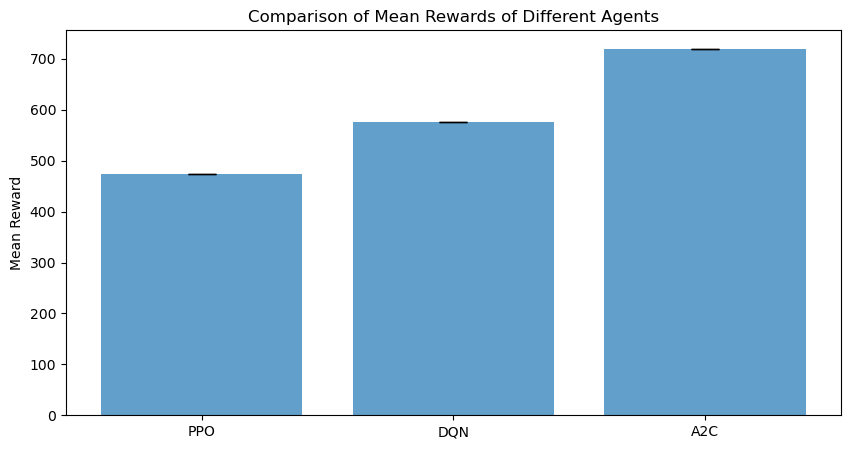

The best model is A2C with a mean reward of 720.0
Mean reward: 474.0
Mean reward: 576.0
Mean reward: 720.0


In [21]:
# Define the agents and their corresponding mean rewards and standard deviations
agents = ['PPO', 'DQN', 'A2C']
mean_rewards = [mean_reward_ppo, mean_reward_dqn, mean_reward_a2c]
std_rewards = [std_reward_ppo, std_reward_dqn, std_reward_a2c]

# Plotting the mean rewards
plt.figure(figsize=(10, 5))
plt.bar(agents, mean_rewards, yerr=std_rewards, align='center', alpha=0.7, ecolor='black', capsize=10)
plt.ylabel('Mean Reward')
plt.title('Comparison of Mean Rewards of Different Agents')
plt.show()

# Determine the index of the best model
best_index = np.argmax(mean_rewards)

print(f"The best model is {agents[best_index]} with a mean reward of {mean_rewards[best_index]}")

for r in mean_rewards:
    print(f"Mean reward: {r}")

---

# Part 2

---

## Enabling action masking, train and test a MaskablePPO agent

In [14]:
# Define a function for the mask
def mask_fn(env):
    return env.get_mask()

# Create an instance of the environment with mask enabled
env = BoundedKnapsackEnv(n_items=200, max_weight=200, mask=True)

# Wrap the environment with the ActionMasker
vec_env = ActionMasker(env, mask_fn)

# Create an evaluation environment
eval_vec_env = Monitor(vec_env)

# Define the policy architecture
policy_kwargs = dict(
    net_arch=dict(pi=[128, 128, 128], vf=[128, 128, 128]),  
)

# Train a MaskablePPO agent
model = MaskablePPO(
    "MlpPolicy",
    vec_env,
    policy_kwargs=policy_kwargs,
    verbose=VERBOSE,
    n_steps=2048,
    batch_size=64,
    learning_rate=3e-4,
)

# Adjust timesteps for meaningful training
model.learn(total_timesteps=TIME_STEPS, use_masking=True)

# Evaluate the agent
mean_reward, std_reward = evaluate_policy_maskable(model, eval_vec_env, n_eval_episodes=EVAL_EPISODES, use_masking=True, deterministic=True)

print(f"Mean reward: {mean_reward} +/- {std_reward}")

c:\Users\20191678\AppData\Local\anaconda3\envs\torch-gpu\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.action_masks to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_masks` for environment variables or `env.get_wrapper_attr('action_masks')` that will search the reminding wrappers.
  logger.warn(


Mean reward: 2219.0 +/- 0.0


## Experiment with different neural network architectures and tune the algorithm hyperparameters

In [16]:
# Define the objective function for MaskablePPO
def maskableppo_objective(trial):
    policy_kwargs = dict(
        net_arch=dict(pi=[128, 128, 128], vf=[128, 128, 128]),  
    )

    # Adjusted hyperparameters suggestion
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-4, log=True)  # Narrower range
    n_steps = trial.suggest_int('n_steps', 2048, 4096)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    n_epochs = trial.suggest_int('n_epochs', 3, 10)
    gamma = trial.suggest_float('gamma', 0.9, 0.9999)
    gae_lambda = trial.suggest_float('gae_lambda', 0.8, 1.0)
    clip_range = trial.suggest_float('clip_range', 0.1, 0.3)  # Adjusted range
    ent_coef = trial.suggest_float('ent_coef', 0.00001, 0.01, log=True)  # Narrower range
    max_grad_norm = trial.suggest_float('max_grad_norm', 0.5, 1.0)  # Gradient clipping

    model = MaskablePPO(
        "MlpPolicy", 
        vec_env, 
        policy_kwargs=policy_kwargs, 
        verbose=0,
        learning_rate=learning_rate, 
        n_steps=n_steps, 
        batch_size=batch_size, 
        n_epochs=n_epochs, 
        gamma=gamma, 
        gae_lambda=gae_lambda, 
        clip_range=clip_range, 
        ent_coef=ent_coef,
        max_grad_norm=max_grad_norm
    )

    model.learn(total_timesteps=TIME_STEPS, use_masking=True)

    mean_reward, _ = evaluate_policy_maskable(model, eval_vec_env, n_eval_episodes=EVAL_EPISODES, use_masking=True, deterministic=True)

    return mean_reward

# Optimize the hyperparameters
maskableppo_study = optuna.create_study(direction='maximize')
maskableppo_study.optimize(maskableppo_objective, n_trials=N_TRIALS)

print('Best hyperparameters for MaskablePPO:', maskableppo_study.best_params)

[I 2024-06-25 08:50:33,258] A new study created in memory with name: no-name-728ca166-e19a-4f93-8432-c8156f1ff9aa
[I 2024-06-25 08:52:01,835] Trial 0 finished with value: 2292.0 and parameters: {'learning_rate': 5.90997669988163e-05, 'n_steps': 3945, 'batch_size': 64, 'n_epochs': 7, 'gamma': 0.9656138871276837, 'gae_lambda': 0.8499390277718211, 'clip_range': 0.17122981067906945, 'ent_coef': 4.854392111683011e-05, 'max_grad_norm': 0.5595498373133915}. Best is trial 0 with value: 2292.0.
[I 2024-06-25 08:53:41,375] Trial 1 finished with value: 2463.0 and parameters: {'learning_rate': 3.339302833522891e-05, 'n_steps': 2150, 'batch_size': 32, 'n_epochs': 8, 'gamma': 0.937693202613854, 'gae_lambda': 0.9299868394028932, 'clip_range': 0.1457262954413872, 'ent_coef': 6.02109474393273e-05, 'max_grad_norm': 0.9037298621736196}. Best is trial 1 with value: 2463.0.
[I 2024-06-25 08:54:53,766] Trial 2 finished with value: 2616.0 and parameters: {'learning_rate': 1.1333726219664428e-05, 'n_steps': 2

Best hyperparameters for MaskablePPO: {'learning_rate': 5.199784939759319e-05, 'n_steps': 3354, 'batch_size': 128, 'n_epochs': 8, 'gamma': 0.9675117568409538, 'gae_lambda': 0.8572440829789219, 'clip_range': 0.17248165234739712, 'ent_coef': 0.00031737766456303246, 'max_grad_norm': 0.7520324320363487}


In [19]:
# Train the best MaskablePPO model
best_params = maskableppo_study.best_params

policy_kwargs = dict(
    net_arch=dict(pi=[128, 128, 128], vf=[128, 128, 128]),  
)

maskableppo_model_best = MaskablePPO(
    "MlpPolicy", 
    vec_env, 
    policy_kwargs=policy_kwargs, 
    verbose=VERBOSE,
    learning_rate=best_params['learning_rate'], 
    n_steps=best_params['n_steps'], 
    batch_size=best_params['batch_size'], 
    n_epochs=best_params['n_epochs'], 
    gamma=best_params['gamma'], 
    gae_lambda=best_params['gae_lambda'], 
    clip_range=best_params['clip_range'], 
    ent_coef=best_params['ent_coef'],
    tensorboard_log=log_dir + 'maskableppo'
)
maskableppo_model_best.learn(total_timesteps=TIME_STEPS, use_masking=True)

# Save the best model
maskableppo_model_best.save("models/maskableppo_tuned_model")

# Evaluate the best model
mean_reward, std_reward = evaluate_policy_maskable(maskableppo_model_best, eval_vec_env, n_eval_episodes=EVAL_EPISODES, use_masking=True, deterministic=True)
print(f"Mean reward for the best MaskablePPO agent: {mean_reward} +/- {std_reward}")

Mean reward for the best MaskablePPO agent: 2633.0 +/- 0.0


## Load & Evaluate the agent then compare the best results obtained with those of the best agent from Part 1.

In [20]:
# Load the best model from Part 1
if agents[best_index] == 'PPO':
    best_model_part1 = PPO.load("models/ppo_tuned_model", env=env)
elif agents[best_index] == 'DQN':
    best_model_part1 = DQN.load("models/dqn_tuned_model", env=env)
elif agents[best_index] == 'A2C':
    best_model_part1 = A2C.load("models/a2c_tuned_model", env=env)
else:
    print("Unknown model type")

# Load the best model from Part 2
best_model_part2 = MaskablePPO.load("models/maskableppo_tuned_model", env=vec_env)

# Evaluate the best model from Part 1
mean_reward_part1, std_reward_part1 = evaluate_policy(best_model_part1, eval_env, n_eval_episodes=EVAL_EPISODES, deterministic=True)

# Evaluate the best model from Part 2
mean_reward_part2, std_reward_part2 = evaluate_policy_maskable(best_model_part2, eval_vec_env, n_eval_episodes=EVAL_EPISODES, deterministic=True, use_masking=True)

# Print the results
print(f"Part 1 - Mean reward: {mean_reward_part1} +/- {std_reward_part1}")
print(f"Part 2 - Mean reward: {mean_reward_part2} +/- {std_reward_part2}")

Part 1 - Mean reward: 720.0 +/- 0.0
Part 2 - Mean reward: 2633.0 +/- 0.0
